In [5]:
import sys

sys.path.append("..")

In [4]:
import torch
torch.cuda.is_available()
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [6]:
import pandas as pd
print(pd.__version__)

1.1.5


In [10]:
!conda install -c conda-forge ray-rllib -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - ray-rllib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            1_gnu          22 KB  conda-forge
    appdirs-1.4.4              |     pyh9f0ad1d_0          13 KB  conda-forge
    attrs-21.2.0               |     pyhd8ed1ab_0          44 KB  conda-forge
    bzip2-1.0.8                |       h7f98852_4         484 KB  conda-forge
    c-ares-1.17.2              |       h7f98852_0         109 KB  conda-forge
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
  

In [17]:
 !conda install -c conda-forge pyfolio -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pyfolio


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    binutils_impl_linux-64-2.36.1|       h193b22a_2        10.4 MB  conda-forge
    binutils_linux-64-2.36     |      hf3e587d_33          22 KB  conda-forge
    empyrical-0.5.5            |     pyh9f0ad1d_0          38 KB  conda-forge
    gcc_impl_linux-64-7.5.0    |      habd7529_19        38.3 MB  conda-forge
    gcc_linux-64-7.5.0         |      h47867f9_33          23 KB  conda-forge
    gxx_impl_linux-64-7.5.0    |      hd0bb8aa_19         9.5 MB  conda-forge
    gxx_linux-64-7.5.0         |      h555fc39_33          23 KB  conda-forge
    h5py-2.10.0                |nompi_py36h4510012_106         1.1 MB  conda-forge
    hdf5-1.10.6                |nompi_h3c11f04_101         3.0 MB  conda-forge
    joblib-1.0.1      

In [18]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.neo_finrl.env_stock_trading.env_stocktrading_np import StockTradingEnv as StockTradingEnv_numpy
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.drl_agents.rllib.models import DRLAgent as DRLAgent_rllib
from finrl.neo_finrl.data_processor import DataProcessor


from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


In [19]:
import zipline

ModuleNotFoundError: No module named 'zipline'

In [20]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


In [21]:
config.START_DATE

'2009-01-01'

In [22]:
config.END_DATE

'2021-01-01'

In [23]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [24]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [25]:
df.shape

(90630, 8)

In [26]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [27]:
processed.sort_values(['date','tic'],ignore_index=True).head(10)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.782837,746015200,AAPL,4,0.0,100.0,66.666667,100.0,0.0
1,2009-01-02,18.570000,19.520000,18.400000,15.657365,10955700,AXP,4,0.0,100.0,66.666667,100.0,0.0
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,0.0,100.0,66.666667,100.0,0.0
3,2009-01-02,44.910000,46.980000,44.709999,32.655109,7117200,CAT,4,0.0,100.0,66.666667,100.0,0.0
4,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4,0.0,100.0,66.666667,100.0,0.0
5,2009-01-02,74.230003,77.300003,73.580002,46.178165,13695900,CVX,4,0.0,100.0,66.666667,100.0,0.0
6,2009-01-02,21.605234,22.060680,20.993229,15.219840,13251037,DD,4,0.0,100.0,66.666667,100.0,0.0
7,2009-01-02,22.760000,24.030001,22.500000,20.597496,9796600,DIS,4,0.0,100.0,66.666667,100.0,0.0
8,2009-01-02,84.019997,87.620003,82.190002,71.965530,14088500,GS,4,0.0,100.0,66.666667,100.0,0.0
9,2009-01-02,23.070000,24.190001,22.959999,17.615519,14902500,HD,4,0.0,100.0,66.666667,100.0,0.0


In [28]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2021-01-01')
print(len(train))
print(len(trade))

75480
15150


In [29]:
config.TECHNICAL_INDICATORS_LIST

['macd', 'rsi_30', 'cci_30', 'dx_30']

In [63]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
from copy import deepcopy

matplotlib.use("Agg")
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib

matplotlib.use("Agg")
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common import logger

class StockTradingEnvV2(gym.Env):
    
    """
    A stock trading environment for OpenAI gym
    Parameters:
    state space: {start_cash, <owned_shares>, for s in stocks{<stock.values>}, }
        df (pandas.DataFrame): Dataframe containing data
        transaction_cost (float): cost for buying or selling shares
        hmax (int): max number of share purchases allowed per asset
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        reward_scaling (float): Scaling value to multiply reward by at each step. 
        initial_amount: (int, float): Amount of cash initially available
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe. 
        out_of_cash_penalty (int, float): Penalty to apply if the algorithm runs out of cash
    


    tests:
        after reset, static strategy should result in same metrics

        buy zero should result in no costs, no assets purchased
        given no change in prices, no change in asset values
    """
    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        transaction_cost_pct=3e-3,
        date_col_name="date",
        hmax=10,
        turbulence_threshold=None,
        print_verbosity=10,
        reward_scaling=1e-4,
        initial_amount=1e6,
        daily_information_cols=["open", "close", "high", "low", "volume"],
        out_of_cash_penalty=None,
        cache_indicator_data = True
    ):
        self.df = df
        self.stock_col = "tic"
        self.assets = df[self.stock_col].unique()
        self.dates = df[date_col_name].sort_values().unique()
        self.df = self.df.set_index(date_col_name)
        self.hmax = hmax
        self.initial_amount = initial_amount
        if out_of_cash_penalty is None:
            out_of_cash_penalty=-initial_amount*0.5
        self.out_of_cash_penalty = out_of_cash_penalty
        self.print_verbosity = print_verbosity
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.daily_information_cols = daily_information_cols
        self.close_index = self.daily_information_cols.index("close")
        self.state_space = (
            1 + len(self.assets) + len(self.assets) * len(self.daily_information_cols)
        )
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.assets),))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.episode = -1  # initialize so we can call reset
        self.seed()
        self.episode_history = []
        self.printed_header = False
        self.cache_indicator_data = cache_indicator_data
        self.cached_data = None
        if self.cache_indicator_data:
            print("caching data")
            self.cached_data = [self.get_date_vector(i) for i, _ in enumerate(self.dates)]
            print("data cached!")
        

    def seed(self):
        pass


    def reset(self):
        self.sum_trades = 0
        self.date_index = 0
        self.episode += 1
        self.actions_memory = []
        self.state_memory = []
        self.account_information = {
            "cash": [],
            "asset_value": [],
            "total_assets": [],
            'reward': []
        }
        self.state_memory.append(
            np.array(
                [self.initial_amount]
                + [0] * len(self.assets)
                + self.get_date_vector(self.date_index)
            )
        )
        return [0 for _ in range(self.state_space)]

    def get_date_vector(self, date, cols=None):
        if (cols is None) and (self.cached_data is not None):
            return self.cached_data[date]
        else:
            date = self.dates[date]
            if cols is None:
                cols = self.daily_information_cols
            trunc_df = self.df.loc[date]
            v = []
            for a in self.assets:
                subset = trunc_df[trunc_df[self.stock_col] == a]
                v += subset.loc[date, cols].tolist()
            assert len(v) == len(self.assets) * len(cols)
            return v
    
    def log_step(self, reason, terminal_reward=None):
        if terminal_reward is None:
            terminal_reward = self.account_information['reward'][-1]
        cash_pct = self.account_information['cash'][-1]/self.account_information['total_assets'][-1]
        rec = [self.episode, self.date_index, reason, f"${int(self.account_information['total_assets'][-1])}",f"${terminal_reward:0.2f}", f"{cash_pct*100:0.2f}%"]

        self.episode_history.append(rec)
        print(self.template.format(*rec))

    def step(self, actions):
        #print header only first time
        if self.printed_header is False:
            self.template = "{0:8}|{1:10}|{2:15}|{3:7}|{4:10}|{5:10}" # column widths: 8, 10, 15, 7, 10
            print(self.template.format("EPISODE", "STEPS", "TERMINAL_REASON", "TOT_ASSETS", "TERMINAL_REWARD_unsc", "CASH_PCT"))
            self.printed_header = True

        # define terminal function in scope so we can do something about the cycle being over
        def return_terminal(reason='Last Date', extra_reward=0):

            state = self.state_memory[-1]
            reward = 0
            reward += extra_reward
            self.log_step(reason = reason, terminal_reward= reward)
            reward = reward*self.reward_scaling
            # Add outputs to logger interface
            reward_pct = self.account_information['total_assets'][-1]/self.initial_amount
            '''logger.record("environment/total_reward_pct", (reward_pct-1)*100)
            logger.record("environment/daily_trades", self.sum_trades/self.date_index)
            logger.record("environment/completed_steps", self.date_index)
            logger.record("environment/sum_rewards", np.sum(self.account_information['reward']))'''
            return state, reward, True, {}

        # print if it's time.
        if (self.date_index + 1) % self.print_verbosity == 0:
            self.log_step(reason = 'update')

        #if we're at the end
        if self.date_index == len(self.dates) - 1:
            #if we hit the end, set reward to total gains (or losses)
            terminal_reward = self.account_information['total_assets'][-1]-self.initial_amount
            return return_terminal(extra_reward = terminal_reward)
        else:
            begin_cash = self.state_memory[-1][0]
            holdings = self.state_memory[-1][1 : len(self.assets) + 1]
            assert (min(holdings)>=0)
            closings = np.array(self.get_date_vector(self.date_index, cols=["close"]))

            # compute current value of holdings
            asset_value = np.dot(holdings, closings)

            # reward is (cash + assets) - (cash_last_step + assets_last_step)
            if self.date_index==0:
                reward = 0
            else:
                reward = (
                    begin_cash + asset_value - self.account_information["total_assets"][-1]
                )

            # log the values of cash, assets, and total assets
            self.account_information["cash"].append(begin_cash)
            self.account_information["asset_value"].append(asset_value)
            self.account_information["total_assets"].append(begin_cash + asset_value)
            self.account_information['reward'].append(reward)

            # multiply action values by our scalar multiplier and save
            actions = actions * self.hmax
            self.actions_memory.append(actions)

            # clip actions so we can't sell more assets than we hold
            actions = np.maximum(actions, -np.array(holdings))
            self.sum_trades += np.sum(np.abs(actions))

            # compute our proceeds from sales, and add to cash
            sells = -np.clip(actions, -np.inf, 0)
            proceeds = np.dot(sells, closings)
            costs = proceeds * self.transaction_cost_pct
            coh = begin_cash + proceeds

            # compute the cost of our buys
            buys = np.clip(actions, 0, np.inf)
            spend = np.dot(buys, closings)
            costs += spend * self.transaction_cost_pct

            # if we run out of cash, end the cycle and penalize
            if (spend + costs) > coh:
                return return_terminal(reason = 'CASH SHORTAGE',
                    extra_reward=self.out_of_cash_penalty,
                )

            # verify we didn't do anything impossible here
            assert (spend + costs) <= coh

            # update our holdings
            coh = coh - spend - costs
            holdings_updated = holdings + actions
            self.date_index += 1
            state = (
                [coh] + list(holdings_updated) + self.get_date_vector(self.date_index)
            )
            self.state_memory.append(state)
            reward = reward * self.reward_scaling
            return state, reward, False, {}

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
    
    def get_multiproc_env(self, n = 10):
        def get_self():
            return deepcopy(self)
        e = SubprocVecEnv([get_self for _ in range(n)], start_method = 'fork')
        obs = e.reset()
        return e, obs

    def save_asset_memory(self):
        self.account_information["date"] = self.dates[: len(self.account_information['cash'])]
        return pd.DataFrame(self.account_information)

    def save_action_memory(self):
        return pd.DataFrame(
            {"date": self.dates[: self.date_index], "actions": self.actions_memory}
        )

In [64]:
print(StockTradingEnvV2.__doc__)


    A stock trading environment for OpenAI gym
    Parameters:
    state space: {start_cash, <owned_shares>, for s in stocks{<stock.values>}, }
        df (pandas.DataFrame): Dataframe containing data
        transaction_cost (float): cost for buying or selling shares
        hmax (int): max number of share purchases allowed per asset
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        reward_scaling (float): Scaling value to multiply reward by at each step. 
        initial_amount: (int, float): Amount of cash initially available
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe. 
        out_of_cash_penalty (int, float): Penalty to apply if the algorithm runs out of cash
    


    tests:
        after reset, static strategy should result i

In [ ]:
information_cols = ['open', 'high', 'low', 'close', 'volume', 'day', 'macd', 'rsi_30', 'cci_30', 'dx_30', 'turbulence']

e_train_gym = StockTradingEnvV2(df = train, 
                              hmax = 100, 
                              out_of_cash_penalty=-1e6,
                              daily_information_cols = information_cols,
                              print_verbosity = 500)

caching data
data cached!


In [ ]:
# for this example, let's do multiprocessing with n_cores-2

import multiprocessing

n_cores = multiprocessing.cpu_count() - 2
#n_cores = 12
print(f"using {n_cores} cores")


env_train, _ = e_train_gym.get_multiproc_env(n = n_cores)
#env_train, _ = e_train_gym.get_sb_env()

using 10 cores
EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  








EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  
       2|       221|CASH SHORTAGE  |$1202265|$-1000000.00|2.46%     
       2|       225|CASH SHORTAGE  |$1203393|$-1000000.00|0.26%     
       2|       228|CASH SHORTAGE  |$1208074|$-1000000.00

Process ForkProcess-8:
Process ForkProcess-10:
Process ForkProcess-6:
Process ForkProcess-1:
Process ForkProcess-9:
Process ForkProcess-2:
Process ForkProcess-3:
Process ForkProcess-4:
Process ForkProcess-5:
Process ForkProcess-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/pyth

In [ ]:
agent = DRLAgent(env = env_train)

In [ ]:
print(config.PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}


In [ ]:
from torch.nn import Softsign, ReLU
ppo_params ={'n_steps': 128, 
             'ent_coef': 0.01, 
             'learning_rate': 0.00025, 
             'batch_size': 256, 
            'gamma': 0.99}

policy_kwargs = {
#     "activation_fn": ReLU,
    "net_arch": [1024, 1024, 1024], 
#     "squash_output": True
}

model = agent.get_model("ppo",  model_kwargs = ppo_params, policy_kwargs = policy_kwargs, verbose = 0)
# model.load("quicksave_ppo_dow.model")

{'n_steps': 128, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 256, 'gamma': 0.99}


In [71]:
model.learn(total_timesteps = 400000, 
            log_interval = 1, tb_log_name = 'ppo_1024_5_more_ooc_penalty',
            reset_num_timesteps = True)

KeyboardInterrupt: 

In [72]:
print(e_train_gym.actions_memory[:2])

AttributeError: 'StockTradingEnvV2' object has no attribute 'actions_memory'

In [39]:
model.save("quicksave_ppo_dow.model")

In [40]:
data_turbulence = processed[(processed.date<'2019-01-01') & (processed.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])


In [41]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       33.278200
std        33.999916
min         0.000000
25%        15.233869
50%        25.166816
75%        39.290032
max       332.849108
Name: turbulence, dtype: float64

In [42]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [43]:
turbulence_threshold

332.8491083629977

In [44]:
def DRL_prediction(model, environment):
    test_env, test_obs = environment.get_sb_env()
    """make a prediction"""
    account_memory = []
    actions_memory = []
    test_env.reset()
    for i in range(len(environment.df.index.unique())):
        action, _states = model.predict(test_obs)
        #account_memory = test_env.env_method(method_name="save_asset_memory")
        #actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        if not dones[0]:
          account_memory = test_env.env_method(method_name="save_asset_memory")
          actions_memory = test_env.env_method(method_name="save_action_memory")
        if dones[0]:
            print("hit end!")
            break
    return account_memory[0], actions_memory[0]

trade = data_split(processed, '2019-01-01','2021-01-01')
e_trade_gym = StockTradingEnvV2(df = trade,hmax = 10, 
                              daily_information_cols = information_cols,
                              print_verbosity = 500)

df_account_value, df_actions = DRL_prediction(model=model,
                        environment = e_trade_gym,)

caching data
data cached!
EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  
       1|        81|CASH SHORTAGE  |$1038704|$-500000.00|0.67%     
hit end!


In [45]:
df_account_value.shape

(81, 5)

In [47]:
df_account_value.tail(50)

,cash,asset_value,total_assets,reward,date
31,628678.649498,3.947154e+05,1.023394e+06,6339.852602,2019-02-15
32,615502.025531,4.075861e+05,1.023088e+06,-305.855417,2019-02-19
33,602893.922880,4.213736e+05,1.024267e+06,1179.321607,2019-02-20
34,592083.630216,4.306160e+05,1.022700e+06,-1567.877652,2019-02-21
35,580498.147392,4.462449e+05,1.026743e+06,4043.397485,2019-02-22
36,568795.965190,4.584609e+05,1.027257e+06,513.861362,2019-02-25
37,555917.340036,4.711566e+05,1.027074e+06,-182.875460,2019-02-26
38,542505.126415,4.875094e+05,1.030015e+06,2940.552759,2019-02-27
39,529284.217443,5.035464e+05,1.032831e+06,2816.073428,2019-02-28
40,515662.962076,5.177251e+05,1.033388e+06,557.418875,2019-03-01


In [48]:
df_actions.to_dict(orient = 'rows')[:3]

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


[{'date': '2019-01-02',
  'actions': array([ 10.       ,  10.       ,  10.       , -10.       , -10.       ,
         -10.       , -10.       ,  -1.2941754, -10.       , -10.       ,
         -10.       , -10.       ,  10.       , -10.       ,  10.       ,
           8.262138 , -10.       ,  10.       , -10.       , -10.       ,
          10.       , -10.       ,  10.       , -10.       , -10.       ,
         -10.       , -10.       ,  10.       ,  -9.187046 , -10.       ],
        dtype=float32)},
 {'date': '2019-01-03',
  'actions': array([ 10.,  10.,  10., -10., -10., -10., -10., -10., -10., -10., -10.,
         -10.,  10., -10.,  10.,  10., -10.,  10., -10., -10.,  10., -10.,
          10., -10., -10., -10., -10.,  10.,  10., -10.], dtype=float32)},
 {'date': '2019-01-04',
  'actions': array([ 10.       ,  10.       ,  10.       , -10.       , -10.       ,
         -10.       , -10.       ,  -7.19285  , -10.       , -10.       ,
         -10.       , -10.       ,  10.       , -10.

In [49]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value, value_col_name = 'total_assets')
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')



==============Get Backtest Results===========
Annual return          0.120114
Cumulative returns     0.037133
Annual volatility      0.067911
Sharpe ratio           1.725015
Calmar ratio           3.298742
Stability              0.190227
Max drawdown          -0.036412
Omega ratio            1.377143
Sortino ratio          2.740470
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.134413
Daily value at risk   -0.008091
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (80, 8)


Start date,2019-01-02
End date,2019-04-26
Total months,3
,Backtest
Annual return,12.814%
Cumulative returns,3.902%
Annual volatility,6.822%
Sharpe ratio,1.82
Calmar ratio,3.52
Stability,0.17
Max drawdown,-3.641%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.64,2019-03-01,2019-03-22,2019-04-25,40
1,0.27,2019-02-06,2019-02-11,2019-02-12,5
2,0.17,2019-01-18,2019-01-24,2019-01-30,9
3,0.15,2019-02-20,2019-02-21,2019-02-22,3
4,0.09,2019-02-13,2019-02-14,2019-02-15,3


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  


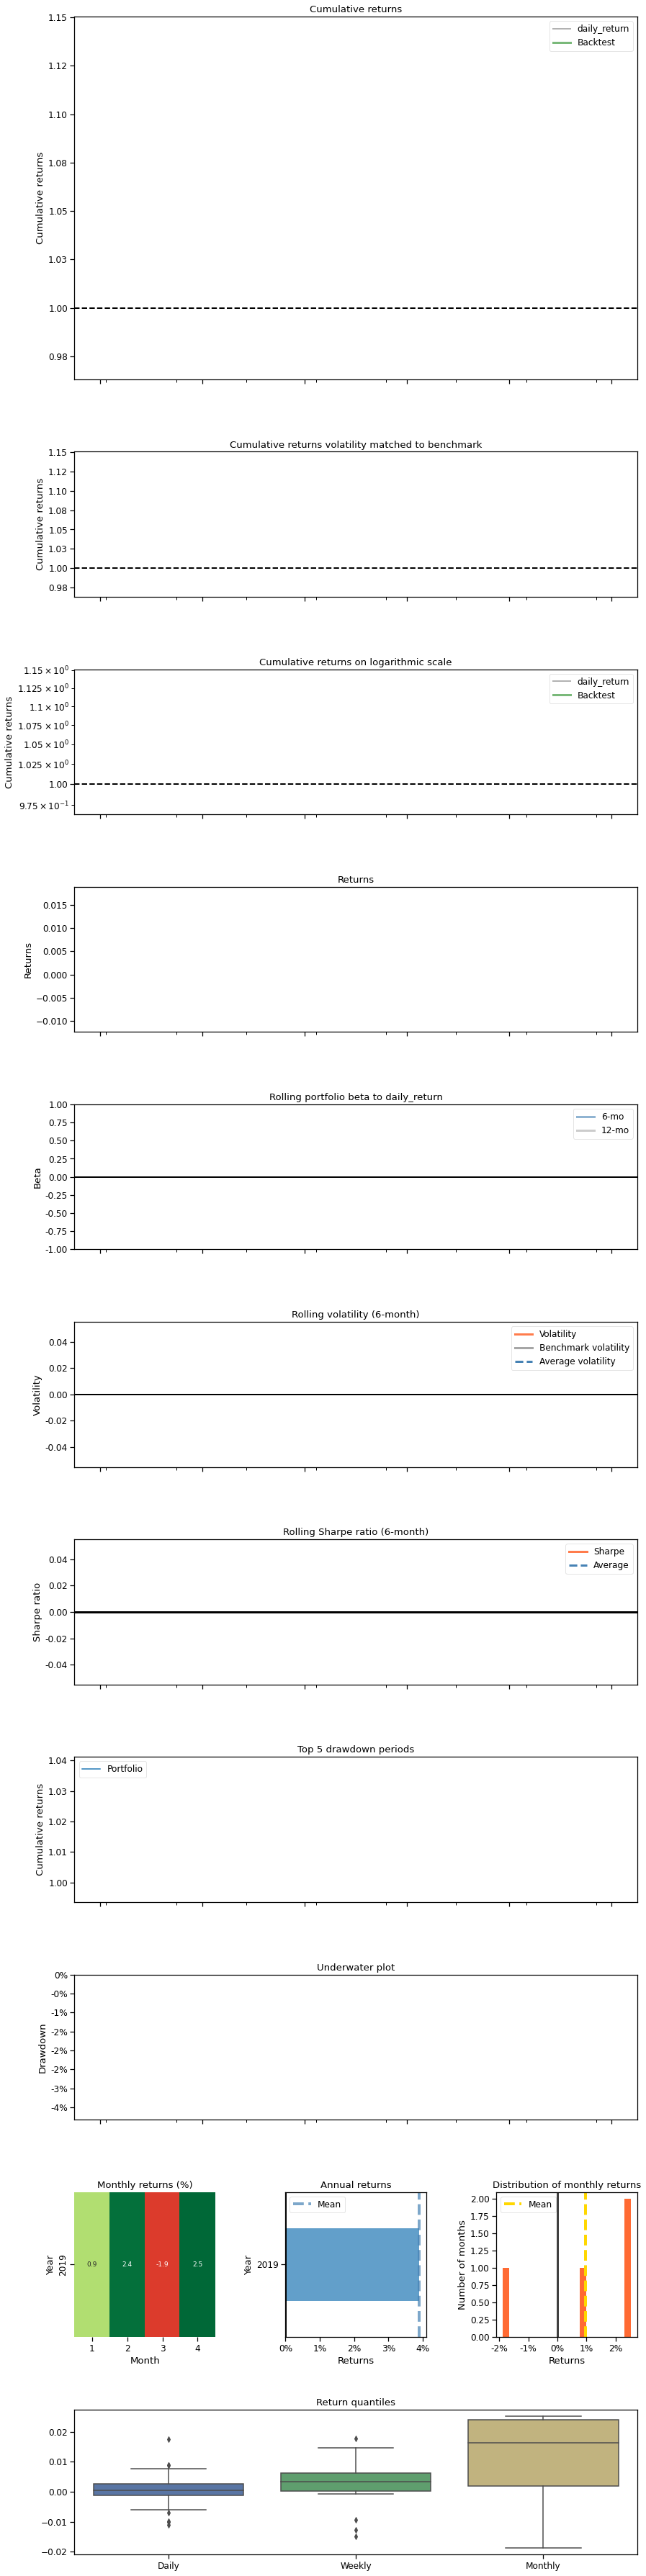

In [50]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.date.values[0],
             baseline_end = df_account_value.date.values[-1], value_col_name = 'total_assets')



In [51]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (80, 8)
Annual return           0.498222
Cumulative returns      0.136942
Annual volatility       0.126931
Sharpe ratio            3.290497
Calmar ratio           17.623127
Stability               0.794158
Max drawdown           -0.028271
Omega ratio             1.823121
Sortino ratio           5.527955
Skew                         NaN
Kurtosis                     NaN
Tail ratio              1.641199
Daily value at risk    -0.014334
dtype: float64
